In [3]:
from f3dasm import ExperimentData
import numpy as np
from pathlib import Path
import pandas as pd
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures # For Polynomial basis functions
from sklearn.pipeline import make_pipeline # to link different objects
from matplotlib import cm # to change colors of surface plots
import matplotlib.pyplot as plt # import plotting tools to create figures

2023-11-17 16:00:20,683 - f3dasm - INFO - Imported f3dasm (version: 1.4.3)


In [4]:
df_in_7d = pd.read_csv('data/supercompressible_7d_input.csv')
df_out_7d = pd.read_csv('data/supercompressible_7d_output.csv')

df_in_3d = pd.read_csv('data/supercompressible_3d_input.csv')
df_out_3d = pd.read_csv('data/supercompressible_3d_output.csv')

In [5]:
X_3d = df_in_3d.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
Y_3d_class = df_out_3d.loc[:, 'coilable'].values
Y_3d_reg = df_out_3d.loc[:,['sigma_crit','energy']].values

In [6]:
# define a function to do the preprocessing
# Input: input_raw_data, output_raw_data, problem_class
# input_raw_data: pandas dataframe for input
# output_raw_data: pandas dataframe for output
# problem_class: (booler) to describe this preprocess is for classification problem or not
#                this will lead to different scaler for Y data.
#
# Output: X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y
# scaler_x: (scaler) used to do inverse_transfer after prediction
# scaler_y: (scaler) used to do inverse_transfer after prediction

def preprocess_3d(input_raw_data,output_raw_data,problem_class):
    if problem_class == False:
        raw_data = pd.concat([input_raw_data, output_raw_data], axis=1)

        # look at the # of missing points in the first ten columns
        raw_data_drop_nan = raw_data.dropna()

        X_3d = raw_data_drop_nan.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = raw_data_drop_nan.loc[:, ['sigma_crit','energy'] ].values
        
        from sklearn.model_selection import train_test_split
        testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        from sklearn.preprocessing import StandardScaler
        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)
        
        scaler_y = StandardScaler()
        scaler_y.fit(Y_train)
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)
    else:
        X_3d = input_raw_data.loc[:, ['ratio_d','ratio_pitch','ratio_top_diameter'] ].values
        Y_3d = output_raw_data.loc[:, 'coilable'].values
        from sklearn.model_selection import train_test_split
        testset_ratio = 0.25
        SEED = 123
        X_train, X_test, Y_train, Y_test = train_test_split(X_3d,
                                            Y_3d, test_size=testset_ratio,
                                            random_state=SEED)

        from sklearn.preprocessing import StandardScaler, FunctionTransformer
        scaler_x = StandardScaler()
        scaler_x.fit(X_train)
        X_train_scale=scaler_x.transform(X_train)
        X_test_scale=scaler_x.transform(X_test)
        X_scale=scaler_x.transform(X_3d)

        scaler_y = FunctionTransformer() # FunctionTransformer without input will give a Identity scaler
        Y_train_scale = scaler_y.transform(Y_train)
        Y_test_scale = scaler_y.transform(Y_test)
        Y_scale = scaler_y.transform(Y_3d)

    return X_train_scale, X_test_scale, X_scale, Y_train_scale, Y_test_scale, Y_scale, scaler_x, scaler_y

In [7]:
X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class, scaler_x_class, scaler_y_class = preprocess_3d(df_in_3d,df_out_3d,True)
X_train_scale_regression, X_test_scale_regression, X_scale_regression, Y_train_scale_regression, Y_test_scale_regression, Y_scale_regression, scaler_x_regression, scaler_y_regression = preprocess_3d(df_in_3d,df_out_3d,False)

In [19]:
# Define function to display classification when fixing "ratio_top_diameter"
# Input: X_data,Y_data,scaler_x, scaler_y,model,sample_index,grid_num=20
# X_data, Y_data, scaler_x: scaled data set for classification
# model: any model for predict classification problem
# sample_index: index of "ratio_top_diameter" pick the fixed ratio want to display
# grid_num: default value = 20, it determine how smooth we would like the contour figure to be, higher grid number lead to more time to compute (approximation 20 leads to 1 min) 
#
# Output: none but gives a figure
def classification_model_plot(X_data,Y_data,scaler_x, scaler_y,model,sample_index,grid_num=20):
    X_data_inverse = scaler_x.inverse_transform(X_data)

    x1, x2, x3 = X_data_inverse[:, 0], X_data_inverse[:, 1], X_data_inverse[:,2]

    x1_data_min, x1_data_max = x1.min(), x1.max() # define min & max of feature 0
    x2_data_min, x2_data_max = x2.min(), x2.max() # define min & max of feature 0
    #x3_data_min, x3_data_max = x3.min() - 0.005, x3.max() + 0.005 # define min & max of feature 0

    #grid_num = 20
    plot_step_1 = (x1_data_max-x1_data_min)/grid_num # defining the meshgrid step size
    plot_step_2 = (x1_data_max-x1_data_min)/grid_num
    plot_step = min((plot_step_1,plot_step_2))

    X1_data_grid, X2_data_grid = np.meshgrid(np.arange(x1_data_min, x1_data_max, plot_step),
                                            np.arange(x2_data_min, x2_data_max, plot_step))

    len(np.arange(x1_data_min, x1_data_max, plot_step))
    len(np.arange(x2_data_min, x2_data_max, plot_step))

    X1_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
    X2_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))
    X3_data_space = np.zeros((len(np.arange(x1_data_min, x1_data_max, plot_step)),len(np.arange(x2_data_min, x2_data_max, plot_step)),len(x3)))

    for i in range(len(np.arange(x1_data_min, x1_data_max, plot_step))):
        for j in range(len(np.arange(x2_data_min, x2_data_max, plot_step))):
            for k in range(len(x3)):
                X1_data_space[i,j,k] = X1_data_grid[j,i]
                X2_data_space[i,j,k] = X2_data_grid[j,i]
                X3_data_space[i,j,k] = x3[k]

    y_class_SVM_pred_disp = model.predict(scaler_x.transform(np.c_[X1_data_space.ravel(), X2_data_space.ravel(), X3_data_space.ravel()]))
    y_class_SVM_pred_disp_grid = y_class_SVM_pred_disp.reshape(X1_data_space.shape)

    temp_sample = sample_index
    temp_disp = scaler_y.inverse_transform(y_class_SVM_pred_disp_grid[:,:,temp_sample])

    temp_x1 = X1_data_space[:,:,temp_sample]
    temp_x2 = X2_data_space[:,:,temp_sample]
    temp_x3 = x3[temp_sample]

    plot_colors = 'ryb' # defining the 3 colors for each category
    n_classes = 3
    target_names = ['Not coilable','coilable','coilable but yield']

    fig2, ax2 = plt.subplots(tight_layout=True)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    ax2.contourf(temp_x2, temp_x1, temp_disp, cmap=cm.RdYlBu, alpha=0.8)

    # Plot the training points
    ax2.scatter(X_data_inverse[temp_sample, 1], X_data_inverse[temp_sample, 0], c=plot_colors[Y_data[temp_sample]],
                    label=(Y_data[temp_sample],X_data_inverse[temp_sample, 2]), edgecolor='black', s=15)

    ax2.set_ylim(temp_x1.min(), temp_x1.max())
    ax2.set_xlim(temp_x2.min(), temp_x2.max())
    ax2.set_ylabel('ratio_d', fontsize=20)
    ax2.set_xlabel('ratio_pitch', fontsize=20)
    #ax2.set_xticks(())
    #ax2.set_yticks(())
    ax2.legend(loc='lower right', borderpad=0, handletextpad=0, fontsize=15)
    ax2.set_title('Support Vector Machine Classifier (SVC) with RBF kernel with ratio_top_diameter', fontsize=20)
    

In [ ]:
# Define function to do the model training and predicting
# Input: X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model
# X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,: scaled data set for classification
# model: any model for predict classification problem
#
# Output: ac_score,pr_score,re_score,f_one_score,con_matrix
# ac_score: accuracy_score with test sample
# pr_score: precision_score with test sample
# re_score: recall_score with test sample
# f_one_score: f1_score with test sample
# con_matrix: confusion_matrix with test sample

def classification_model_train_and_predict(X_train,X_test,X_data,Y_train,Y_test,Y_data,scaler_x, scaler_y,model):
    model.fit(X_train,Y_train)
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    Y_predict_for_test = model.predict(X_test)
    ac_score = accuracy_score(Y_test,Y_predict_for_test)
    pr_score = precision_score(Y_test,Y_predict_for_test,average='micro')
    re_score = recall_score(Y_test,Y_predict_for_test,average='micro')
    f_one_score = f1_score(Y_test,Y_predict_for_test,average='micro')
    con_matrix = confusion_matrix(Y_test,Y_predict_for_test)

    classification_model_plot(X_data,Y_data,scaler_x, scaler_y,model,5,20)

    return ac_score,pr_score,re_score,f_one_score,con_matrix

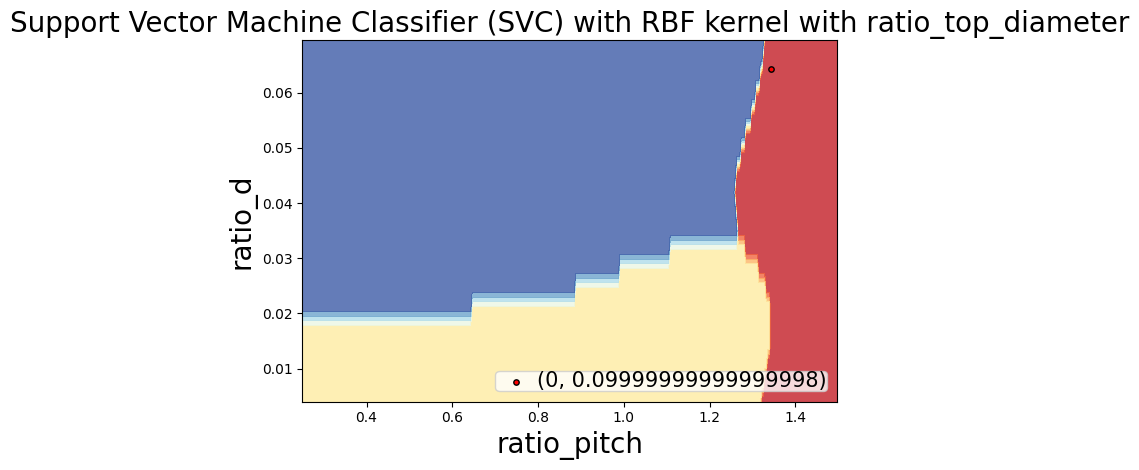

In [20]:
from sklearn import svm
# we create an instance of SVM and fit out data. We did not scale our data (this dataset is quite simple)

SVM_model = svm.SVC(kernel='rbf',gamma=0.7,C=1.0) # - kernel like in GPs
                                                    # - gamma is the kernel hyperparameter (here: length-scale)
                                                    # - C is a l2 regularization parameter (strength of 
                                                    #   regularization is inversely proportional to C)

ac_score,pr_score,re_score,f_one_score,con_matrix = classification_model_train_and_predict(X_train_scale_class, X_test_scale_class, X_scale_class, Y_train_scale_class, Y_test_scale_class, Y_scale_class,scaler_x_class, scaler_y_class,SVM_model)

In [30]:
print(ac_score)
print(pr_score)
print(re_score)
print(f_one_score)
print(con_matrix)

0.816
0.816
0.816
0.816
[[ 70   5   3]
 [  6  32  15]
 [  7  10 102]]
